<a href="https://colab.research.google.com/github/meriemdouider1/2/blob/main/a1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical# convert to one-hot-encoding
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
%matplotlib inline
from glob import glob
from keras import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from tqdm import tqdm_notebook
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import load_model, Model


KeyboardInterrupt: ignored

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download "sshikamaru/glaucoma-detection"

In [ ]:
!unzip glaucoma-detection.zip

# **Problématique :**


Il existe de nombreuses maladies de l’œil. Chaque partie anatomique de cet organe peut présenter un désordre et causer un trouble oculaire. Il est important pour le patient de bien comprendre la nature de son trouble oculaire afin de prendre bien soin de sa condition visuelle. Cela permet aussi de mieux prendre en charge une maladie et de dépister les signes indiquant une détérioration. Un patient informé et averti a plus de chances d’être traité à temps, de se sentir en confiance et d’observer son traitement.
Le glaucome est une maladie de l’œil qui touche de manière irréversible et permanente le nerf optique (atteinte structurelle). Le nerf optique est la partie de l’œil par où transite toute l’information visuelle captée par l’œil. Cette information voyage par le nerf optique et est transmise au cerveau.
**Glaucoma**
Le glaucome est une maladie très fréquente qui touche des gens de tous âges. Selon les sources, on estime qu’il y aurait jusqu’à 10 % de la population qui en serait atteinte. Au Canada, ce nombre représente 250 000 personnes. À l’échelle mondiale, ceci représente 65 millions d’individus.

Le glaucome peut se présenter sous diverses formes. On en dénombre pas moins d’une soixantaine. Nous présentons ci-dessous certaines formes les plus courantes .
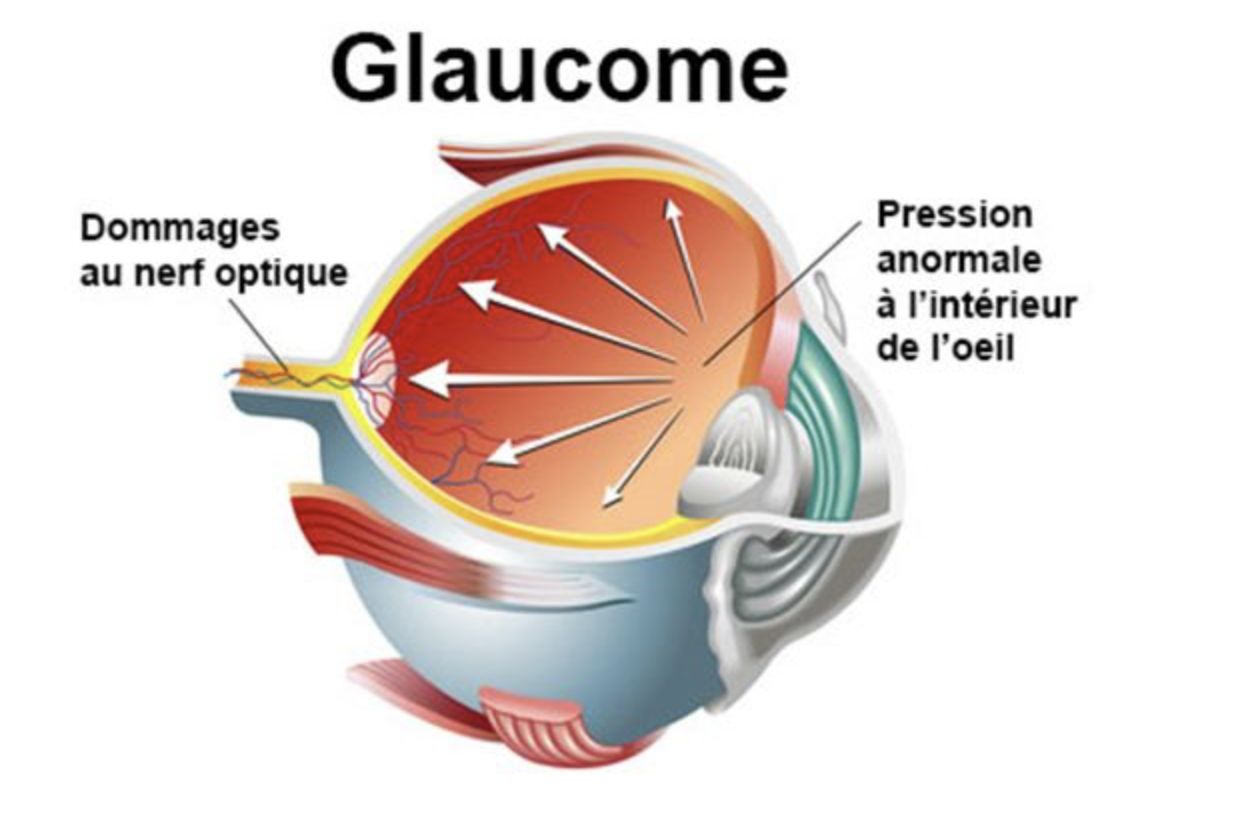

# **Présentation des données :**

In [ ]:
### les informations sur notre base des données images  :

In [ ]:
## charge de l'image :
image = Image.open('/content/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Positive/036.jpg')


In [ ]:
# affichage les informations de l'image
print(image.format)
print(image.mode)
print(image.size)

*affichage des images :*

In [ ]:
def creation_data(Data, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(Data)):
        PATH = os.path.join(Data,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

In [ ]:
def affichage_images(data,etat):
    f, ax = plt.subplots(5,5, figsize=(15,15))
    for i in range(25):
        img_data = data[i]
        if etat  == 0: 
            str='Gluacoma_Negative'
        elif etat == 1: 
            str='Gluacoma_positive'
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("état: {}".format(str))
    plt.show()

affichage des images (Train_Gluacoma_Negative)

In [ ]:
T_Glaucoma_N = '/content/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative'

In [ ]:
Train_G_N = creation_data(T_Glaucoma_N ,224)

In [ ]:
##nombre des images avec un cas de Glaucoma_Negative (données train)
len(Train_G_N)

In [ ]:
affichage_images(Train_G_N,0)

affichage des images (Train_Gluacoma_Positive)

In [ ]:
T_Glaucoma_P = '/content/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Positive'
Train_G_P = creation_data(T_Glaucoma_P ,224)

In [ ]:
##nombre des images avec un cas de Glaucoma_Positive (données train)
len(Train_G_P)

In [ ]:
affichage_images(Train_G_P,1)

# **Transfer learning**

Qu'est-ce que l'apprentissage par transfert?

L'apprentissage par transfert est une approche utilisée dans l'apprentissage automatique dans lequel un modèle créé et formé pour une tâche est réutilisé comme point de départ d'une tâche secondaire. L'apprentissage par transfert diffère de l'apprentissage automatique traditionnel car il implique l'utilisation d'un modèle pré-entraîné comme tremplin pour démarrer une tâche secondaire.

Cette approche imite la façon dont les humains appliquent les connaissances acquises pour une tâche à une nouvelle tâche. Par exemple, John Doe a appris à lire en première année. En dixième année, John a utilisé ses capacités de lecture en classe de chimie. Les connaissances qu'il avait acquises de la tâche principale (apprendre à lire) sont devenues la base sur laquelle il a commencé la tâche secondaire (apprendre la chimie).



Les avantages de l'utilisation de l'apprentissage par transfert et de l'apprentissage profond :

Prendre un modèle qui a déjà été formé dans un domaine spécifique et le réappliquer à un autre domaine présente de nombreux avantages. Certains des principaux avantages sont énumérés ci-dessous.

- Moins de données d'entraînement: commencer à entraîner un modèle à partir de zéro demande beaucoup de travail et nécessite beaucoup de données. Par exemple, si nous voulons créer un nouvel algorithme capable de détecter un froncement de sourcils, nous avons besoin de beaucoup de données d'entraînement. Notre modèle devra d'abord apprendre à détecter les visages, et ce n'est qu'alors qu'il pourra apprendre à détecter des expressions, telles que les froncements de sourcils. Au lieu de cela, si nous utilisons un modèle qui a déjà appris à détecter les visages et que nous recyclons ce modèle pour détecter les froncements de sourcils, nous pouvons obtenir le même résultat en utilisant beaucoup moins de données.
Les modèles se généralisent mieux 
- l'utilisation de l'apprentissage par transfert sur un modèle prépare le modèle à bien fonctionner avec des données sur lesquelles il n'a pas été formé. C'est ce qu'on appelle la généralisation. Les modèles qui ont été formés à l'aide de l'apprentissage par transfert sont mieux à même de généraliser d'une tâche à une autre car ils ont été formés pour apprendre à identifier les fonctionnalités qui peuvent être appliquées à de nouveaux contextes.
Rend l'apprentissage en profondeur plus accessible 
- l'utilisation de l'apprentissage par transfert facilite l'utilisation de l'apprentissage en profondeur. Il est possible d’obtenir les résultats souhaités sans être un expert en deep learning, en utilisant un modèle créé par un spécialiste du deep learning et en l’appliquant à un nouveau problème.

####Préparation des données entraînement /test / validation : 



In [ ]:
DATAGlua_Train = '/content/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train'
DATAGlua_Test = '/content/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation'

notre jeu deux de données est divisé en deux partie : 
*   des données avec un Gluacoma_positive
*   des données avec un Gluacoma_négative



In [ ]:
CATEGORIES  = list()
for root, dirs, files in os.walk(DATAGlua_Train, topdown=False):
    for name in dirs:
        CATEGORIES.append(os.path.join(name))
print (CATEGORIES)


Division l'ensemble de données d'entraînement en x_train_data et y_train_data  : (x_train_data : 'les images' , y_train_data : 'label / catégorie ')

In [ ]:
x_train_data = []
y_train_data = []
IMG_SIZE=224
def creation_train_data():
    for category in CATEGORIES:
      path = os.path.join(DATAGlua_Train, category)
      class_num = CATEGORIES.index(category)
      for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            x_train_data.append(new_array)
            y_train_data.append(class_num)
        except Exception as e:
            pass
creation_train_data()

Division l'ensemble de données test en x_test_data et y_test_data  : (x_test_data : 'les images' , y_test_data : 'label / catégorie ')




In [ ]:
x_test_data = []
y_test_data = []
IMG_SIZE=224
def creation_test_data():
    for category in CATEGORIES:
      path = os.path.join(DATAGlua_Test, category)
      class_num = CATEGORIES.index(category)
      for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            x_test_data.append(new_array)
            y_test_data.append(class_num)
        except Exception as e:
            pass
creation_test_data ()

Division l'ensemble de données x_train_data et y_train_data en données d’entraînement (X_Train,Y_Train) et données de validation   (Y_train,Y_val) 

In [ ]:
X_Train, X_Val, Y_Train, Y_Val = train_test_split(x_train_data, y_train_data, test_size=0.05, random_state=1)

In [ ]:
len(Y_Train)

In [ ]:
len(Y_Val)

In [ ]:
X_Train = np. squeeze(np.array(X_Train))
X_Val = np. squeeze(np.array(X_Val))
Y_Train = np. squeeze(np.array(Y_Train))
Y_Val = np. squeeze(np.array(Y_Val))
x_test_data = np. squeeze(np.array(x_test_data))

In [ ]:
X_Train.shape

In [ ]:
X_Val.shape

In [ ]:
Y_Train.shape

In [ ]:
Y_Val.shape

In [ ]:
x_test_data.shape

In [ ]:
Y_Train = to_categorical(Y_Train)
Y_Val = to_categorical(Y_Val)

In [ ]:
Y_Train.shape

In [ ]:
Y_Val.shape

# **Transfer learning**

# **Création du modèle**: 


Qu'est-ce qu'un modèle pré-entraîné ?
Un modèle pré-entraîné a été préalablement formé sur un ensemble de données et contient les pondérations et les biais qui représentent les caractéristiques de l'ensemble de données sur lequel il a été formé. Les fonctionnalités apprises sont souvent transférables à différentes données. Par exemple, un modèle formé sur un grand ensemble de données d'images d'oiseaux contiendra des caractéristiques apprises telles que des arêtes ou des lignes horizontales que vous seriez transférables à votre ensemble de données.


## **modèle 1 :** 

**Inceptionv3**

Inceptionv3 est un réseau neuronal convolutif destiné à aider à l'analyse d'images et à la détection d'objets, et a fait ses débuts en tant que module pour Googlenet. Il s'agit de la troisième édition du Inception Convolutional Neural Network de Google, initialement présenté lors du Défi de reconnaissance ImageNet. Tout comme ImageNet peut être considéré comme une base de données d'objets visuels classifiés, Inception facilite la classification des objets dans le monde de la vision par ordinateur. Une de ces utilisations est dans les sciences de la vie, où elle aide à la recherche sur la leucémie. Le nom original (Inception) a été nommé de cette façon après qu'un mème Internet populaire «nous devons aller plus loin» est devenu viral, citant une phrase du film Inception de Christopher Nolan. 
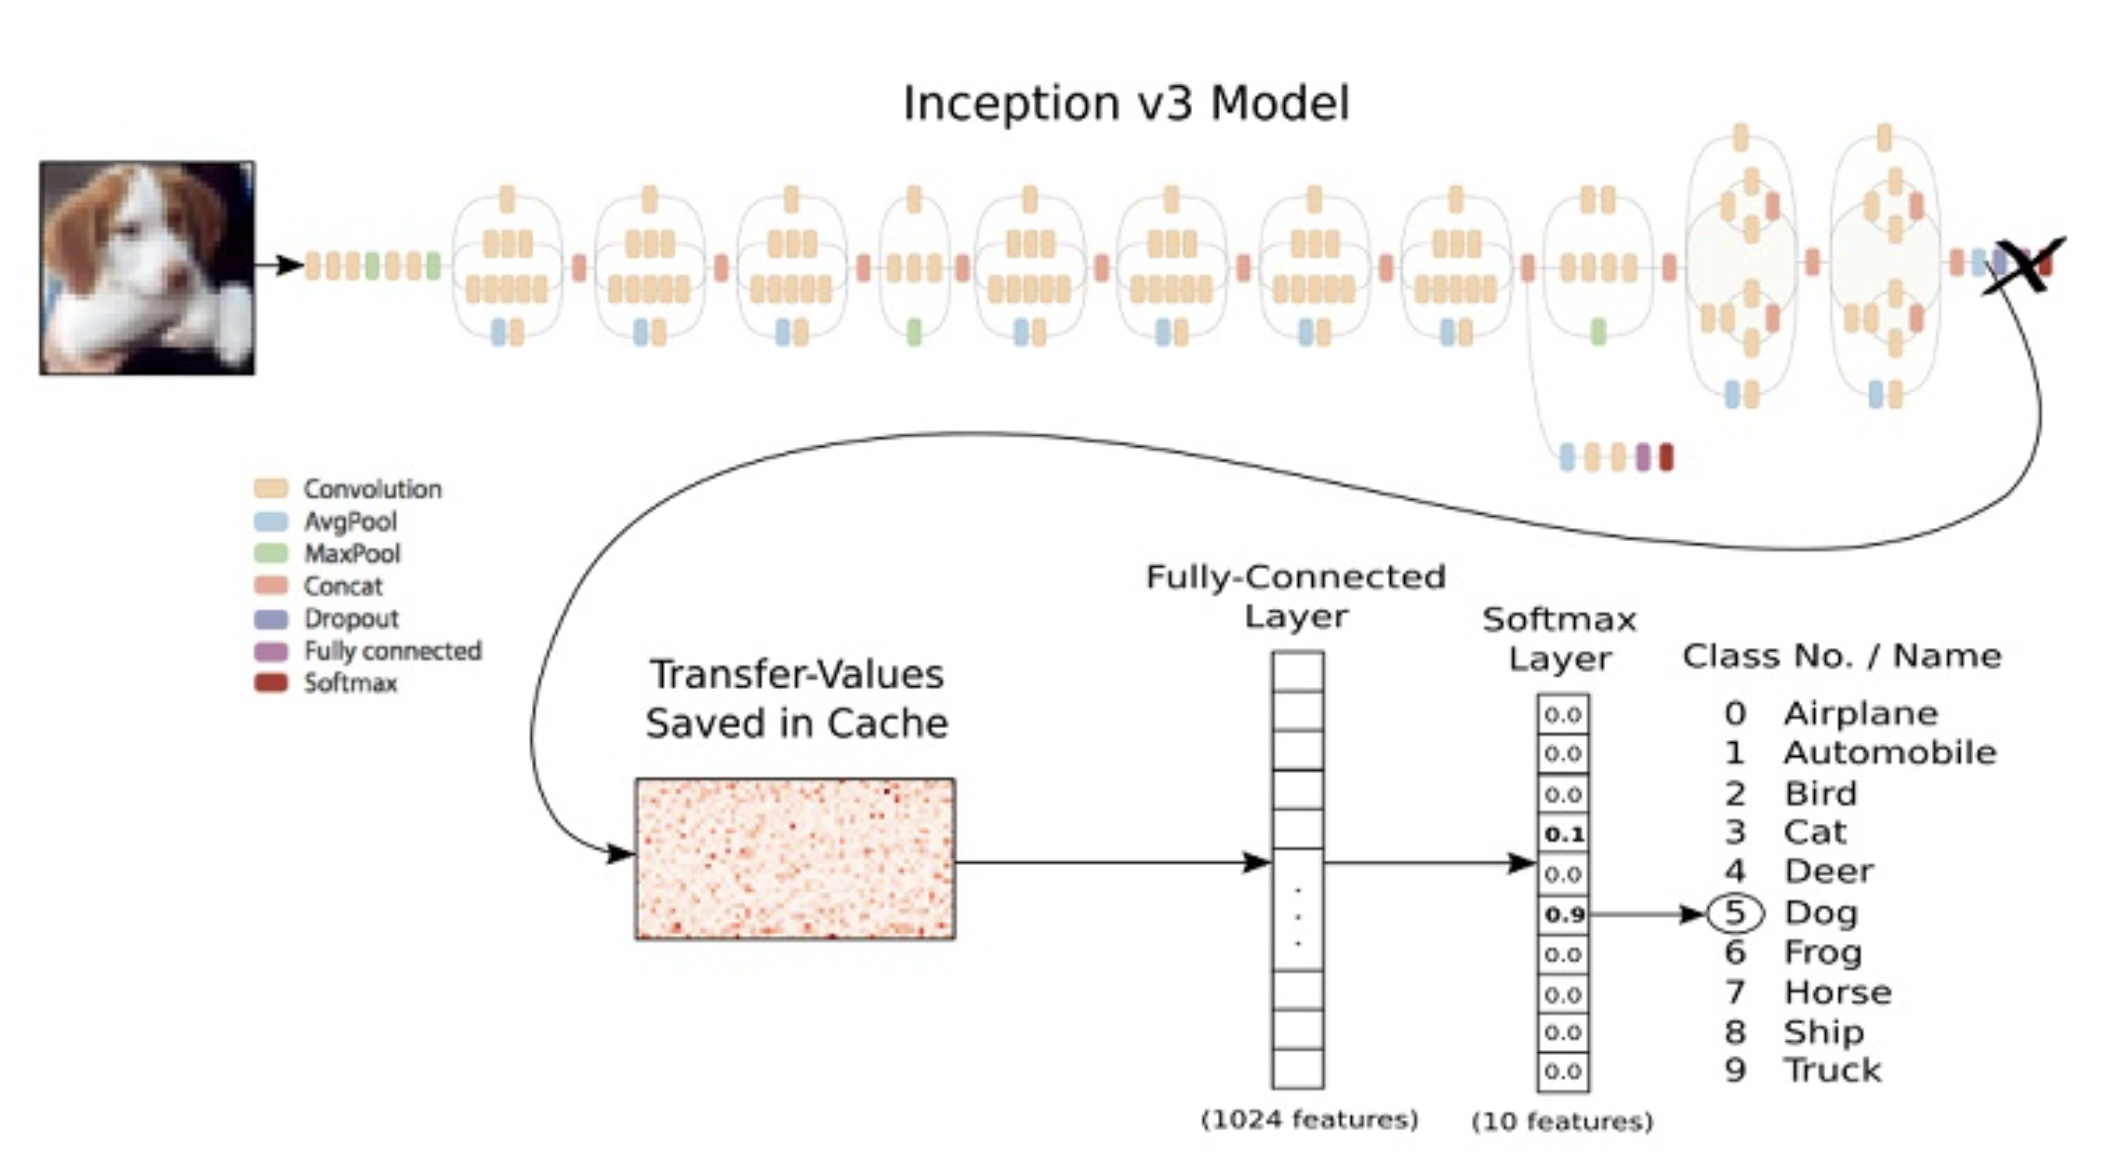
https://software.intel.com/content/www/us/en/develop/articles/inception-v3-deep-convolutional-architecture-for-classifying-acute-myeloidlymphoblastic.html


 L'un des modèles les plus connus pouvant être utilisés pour l'apprentissage par transfert est Inception V3.

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
IMG_SHAPE = (224, 224,3)

importer le modèle pré-entraîne Inception V3 :

In [ ]:
#datagen= ImageDataGenerateur(rescale=1.0/255)
base_model1 = InceptionV3(include_top=False,
                   input_shape=IMG_SHAPE,
                   pooling='avg',classes=2,
                   weights='imagenet')


affichage les layer du modèle Inception_v3 et Figer le modèle pré-entraine en utilisant la commande layer.trainable = False

In [ ]:
for layer in base_model1.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(base_model1.layers))

In [ ]:
base_model1.summary()

In [ ]:
base_model1.trainable = False

In [ ]:
from tqdm import tqdm_notebook
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import load_model, Model
from keras.optimizers import RMSprop


Création d'un nouveau modèle qui va se baser sur les résultas du modèle pré-entraîne :

In [ ]:
# Flatten the output layer to 1 dimension
x = Flatten ()(base_model1.output)
# Ajouter une couche entièrement connectée avec 512 unités cachées et l'activation ReLU
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
# Ajouter une dernière couche sigmoïde pour la classification
x = layers.Dense(2, activation='sigmoid')(x)

In [ ]:
# Configurer et compiler le modèle
model1 = Model(base_model1.input, x)
optimizer = RMSprop(lr=0.0001)
model1.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
model1.summary()


une étape importante avant d'entrainer le modèle est la normalisation pour mettre à l'échelle les valeurs d'entrée (initialement dans la plage [0, 255]) à la plage [0, 1]. cette normalisation est effectuée en utilisant la fonction ImageDataGenerator . catte fonction va nous permis de normaliser les données d'entrée test et validation. cette fonction est utilisable aussi pour l'augmentation des données .

Augmentation et normalisation du données test :

In [ ]:
train_datagen = ImageDataGenerator(
    validation_split=0.2, 
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.02,
)
train_iterator= train_datagen.flow(
    x=X_Train,
    y=Y_Train,
    batch_size=16,
    subset='training'
)

In [ ]:
reshaped_train_x = X_Train.reshape((494, 224, 224, 3))
plt.gcf().set_size_inches(10, 10)
for x_batch, y_batch in train_iterator:
    for i in range(0, 16):
        plt.subplot(4, 4, i+1)
        plt.imshow(x_batch[i])
    break

In [ ]:
val_datagen=ImageDataGenerator(rescale=1./255)


Entraînement du modèle avec des layers du modèle pré-entrâine ( en mode freeze)

In [ ]:
train_model = model1.fit(train_iterator,epochs=25,
                    validation_data=val_datagen.flow(X_Val, Y_Val))


# **fine-tuning**

dégelons maintenant le modèle de base et formons l'ensemble du modèle de bout en bout avec un faible taux d'apprentissage.

Il est important de noter que bien que le modèle de base devienne entraînable, il fonctionne toujours en mode inférence puisque nous avons passé training = False lors de son appel lorsque nous avons construit le modèle.

In [ ]:
for layer in model1.layers:
    layer.trainable = True

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model1.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [ ]:
model1.summary()

In [ ]:
train_model = model1.fit(train_iterator, epochs=35,
                    validation_data=val_datagen.flow(X_Val, Y_Val))

In [ ]:
loss_val, acc_val = model1.evaluate(X_Val, Y_Val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))


Test :

In [ ]:
y_test_data = to_categorical(y_test_data)
loss_test, acc_test = model1.evaluate(x_test_data, y_test_data, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

In [ ]:
model1.save("V3")

In [ ]:
#accuracy est un moyen de mesurer la fréquence à laquelle l'algorithme classe correctement un point de données.
# acc contient les valeurs des accuracy pour les données test  :
acc = train_model.history['acc']
# val_acc contient les valeurs des accuracy pour les données validation   :
val_acc = train_model.history['val_acc']

#loss_function : Cette fonction calculera essentiellement les performances de notre modèle en comparant ce que le modèle prédit avec la valeur réelle qu'il est censé produire.
# loss contient les valeurs du loss_function pour les données test  :
loss = train_model.history['loss']
# val_loss contient les valeurs du loss_function pour les données test  :
val_loss = train_model.history['val_loss']

#les nombre des epochs pour comparer les valeurs des accuracy ou les valeurs des loss function par rapport à leur évolution par rapport au nomre des epochs
epochs = range(len(acc))

# le première graph représente les valeurs des accuracy pour les données test et validation par rapport au nombre des epochs 
plt.plot(epochs, acc,color='r',label = "training")
plt.plot(epochs, val_acc,color='g',label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()
#le deuxième graph représente les valeurs des accuracy pour les données test et validation par rapport au nombre des epochs 
plt.plot(epochs, loss,color='r', label = "training")
plt.plot(epochs, val_loss,color='g',label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')